In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_csv("../data/raw/creditcard.csv")
labels = df["Class"]
df = df.drop(columns=["Class"])


In [3]:
scaler = StandardScaler()
df["Amount_scaled"] = scaler.fit_transform(df[["Amount"]])

df["transaction_count"] = 1
df["tx_per_min"] = df["transaction_count"].rolling(window=60).sum()

df["rolling_mean_amount"] = df["Amount"].rolling(window=60).mean()
df["rolling_std_amount"] = df["Amount"].rolling(window=60).std()

df["hour"] = (df["Time"] // 3600) % 24

df = df.fillna(0)

X = df.values


In [4]:
model = IsolationForest(
    n_estimators=100,
    contamination=0.01,
    random_state=42
)
model.fit(X)


,n_estimators,100
,max_samples,'auto'
,contamination,0.01
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [5]:
anomaly_scores = model.decision_function(X)


- Lower score = more anomalous

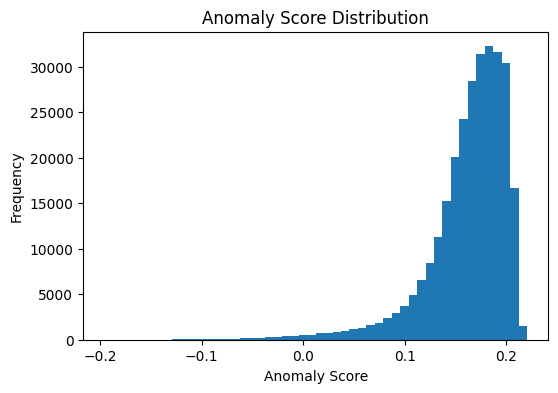

In [6]:
plt.figure(figsize=(6,4))
plt.hist(anomaly_scores, bins=50)
plt.title("Anomaly Score Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()


- One large cluster (normal)

- Long tail (suspicious behavior)

In [7]:
threshold = np.percentile(anomaly_scores, 1)
threshold


np.float64(-2.920019030717112e-17)

**Thresholds were chosen using percentile-based risk tolerance rather than labeled optimization.**

In [8]:
df["anomaly_flag"] = anomaly_scores < threshold


In [9]:
pd.crosstab(df["anomaly_flag"], labels)


Class,0,1
anomaly_flag,,
False,281751,207
True,2564,285


**Since fraud labels aren’t available in real time, I evaluated the model using anomaly score distributions and percentile-based thresholds.**

In [20]:
import sys
import os

sys.path.append(os.path.abspath(".."))


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from src.features import build_features

In [22]:
DATA_PATH = "../data/raw/creditcard.csv"
MODEL_PATH = "../models/isolation_forest.pkl"
SCALER_PATH = "../models/scaler.pkl"


In [23]:
df = pd.read_csv(DATA_PATH)
labels = df["Class"]  # Optional: only for sanity check
df_features = df.drop(columns=["Class"])

print("Data shape:", df_features.shape)

Data shape: (284807, 30)


In [24]:
model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)


In [25]:
X, _, feature_df = build_features(df_features, scaler=scaler)

print("Feature matrix shape:", X.shape)


Feature matrix shape: (284807, 36)


In [26]:
anomaly_scores = model.decision_function(X)  # Higher = normal, Lower = anomalous

feature_df["anomaly_score"] = anomaly_scores


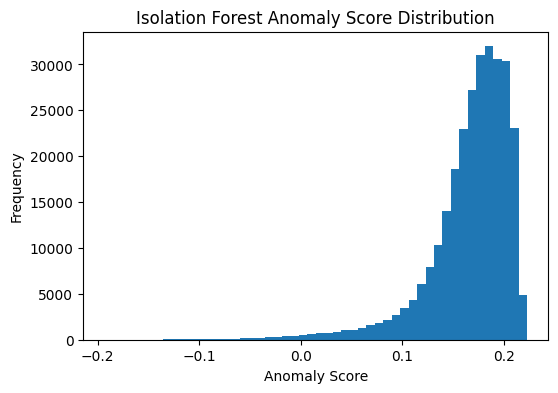

In [27]:
plt.figure(figsize=(6,4))
plt.hist(anomaly_scores, bins=50)
plt.title("Isolation Forest Anomaly Score Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()

In [28]:
percentile = 1  # bottom 1% flagged
threshold = np.percentile(anomaly_scores, percentile)

print(f"Anomaly score threshold (bottom {percentile}%): {threshold:.4f}")

# Flag anomalies
feature_df["anomaly_flag"] = anomaly_scores < threshold


Anomaly score threshold (bottom 1%): -0.0000


In [29]:
sanity_check = pd.crosstab(feature_df["anomaly_flag"], labels)
print("\nSanity check (anomalies vs actual fraud):\n", sanity_check)


Sanity check (anomalies vs actual fraud):
 Class              0    1
anomaly_flag             
False         281722  236
True            2593  256


In [30]:
feature_df.to_csv("../data/processed/evaluated_features.csv", index=False)
print("\nEvaluated features with scores saved.")


Evaluated features with scores saved.
